In [2]:
import numpy as np
import math
import pandas as pd
from astropy.io import fits

#Set up matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as plc

# from sed_evaluation import non_param_sfr_sed,generate_total_SED,sed,c,wave_freq,u,use_wave
# from sed_evaluation import non_param_sfr_sed,generate_total_SED,sed,c,wave_freq,u,use_wave
import sed_evaluation as sed
from scipy.integrate import quad


# Defining some functions

In [7]:
def sed_simulation(param): #
    ## Some definitions ##
    # param[0]: log10 SFR in the first 10 Myr
    # param[1]: log10 SFR in the 10-100 Myr
    # param[2]: log10 SFR in the 100 - 1000 Myr
    
    p = np.power(10, param)
    sfr_fn = lambda t: p[0] * (t<1e7) + p[1] * (t>1e7) * (t<1e8) + p[2] * (t>1e8) * (t<1e9)
    sed_sim = sed.generate_total_SED(sfr_fn, sed.sed)
    return sed_sim

def integrand(wavelength):
    sed_interpolate = np.interp(wavelength, np.log10(sed.sed.get_wavelength()), np.log10(sed_simulation([0,0,10])))
    throughput=np.interp(wavelength,jwst_waves,jwst_throughput)
    total = sed_interpolate*throughput
    return total

def sersic_profile(radius):
    intensity_value = float(100*np.exp(-5*(((radius/10)**0.25)-1)))
    return intensity_value

def transformation(smallest_pixel, galaxy_distance, magnification,row,column):
    ## Some definitions of the parameters ##
    # smallest_pixel = the width of each pixel in radians; 
    # galaxy_distance = the distance of the galaxy (watch out for units!);
    # magnification = the magnification of the galaxy; 
    # row, column = the coordinate of a pixel
    
    galaxy_pixel_radius = math.sqrt((column-center_i)**2+(row-center_j)**2) #center_i and center_j has not been generalized yet
    galaxy_pixel_angle=smallest_pixel*galaxy_pixel_radius # Calculating the angular size of a radius of a galaxy in the pixel array
    galaxy_radius=galaxy_distance*galaxy_pixel_angle # Using the distance formula to calculate the true galaxy radius
                                                            # we observe
    return galaxy_radius



# Generating the galaxy image based on the Sersic Profile

<IPython.core.display.Javascript object>


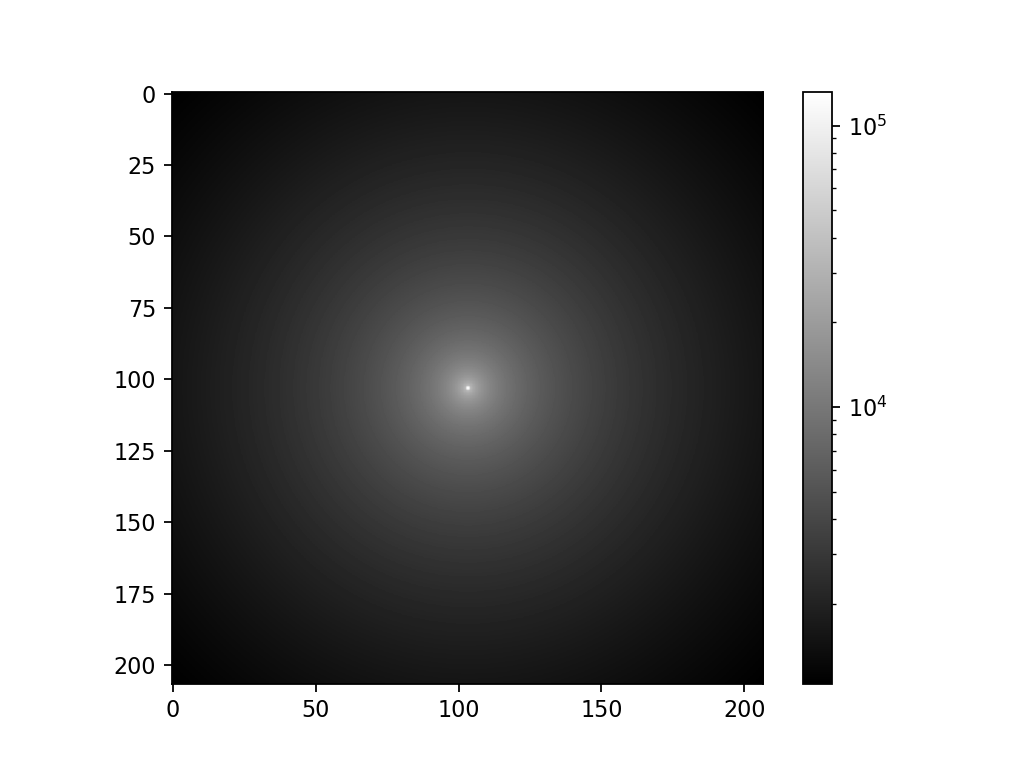

In [8]:
%matplotlib notebook

file_name=['F070W','F090W','F115W','F140M','F150W','F150W2','F162M','F164N','F444W']

filter_intensity=[]
for file in file_name:
    data  = pd.read_csv("{0}.csv".format(file))
    xdata = data.microns # Wavelength in units of micrometer
    ydata = data.throughput # The throughput for each wavelength in jwst_wave
    sed_waves = sed.use_wave/10**4


    jwst_waves=[]
    for wave in xdata:
        jwst_waves.append(wave)


    jwst_throughput = []
    for throughput in ydata:
        jwst_throughput.append(throughput)


    function = integrand(jwst_waves)
    delta_lambda=np.abs(np.array(jwst_waves[1:])-np.array(jwst_waves[:-1]))
    result = np.sum((function[1:]+function[:-1])*delta_lambda)/2
    filter_intensity.append(result)



pixel_scale = 0.063 # In arcseconds, this is the angular size per pixel
telescope_focal=100 # In arbitrary units, this is the telescope focal length
eyepiece_focal=10 # In arbitrary units, this is the eyepiecec focal length
magnification=telescope_focal/eyepiece_focal # Magnification of the galaxy image

n=101 # Just a random number to generate the amount of pixel
total_rows=2*n+5
total_columns=2*n+5
a = np.zeros(shape=(total_rows,total_columns,len(filter_intensity)))
center_i = int((total_rows-1)/2)
center_j = int((total_columns-1)/2)



for i in range(total_rows):
    for j in range(total_columns):
        for k in range(len(filter_intensity)):
            a[i][j][k]=sersic_profile(transformation(0.06,1,10,i,j))*filter_intensity[k]
    

plt.imshow(a[:,:,2], cmap='gray',norm=plc.LogNorm())
plt.colorbar()

    

1221


<IPython.core.display.Javascript object>


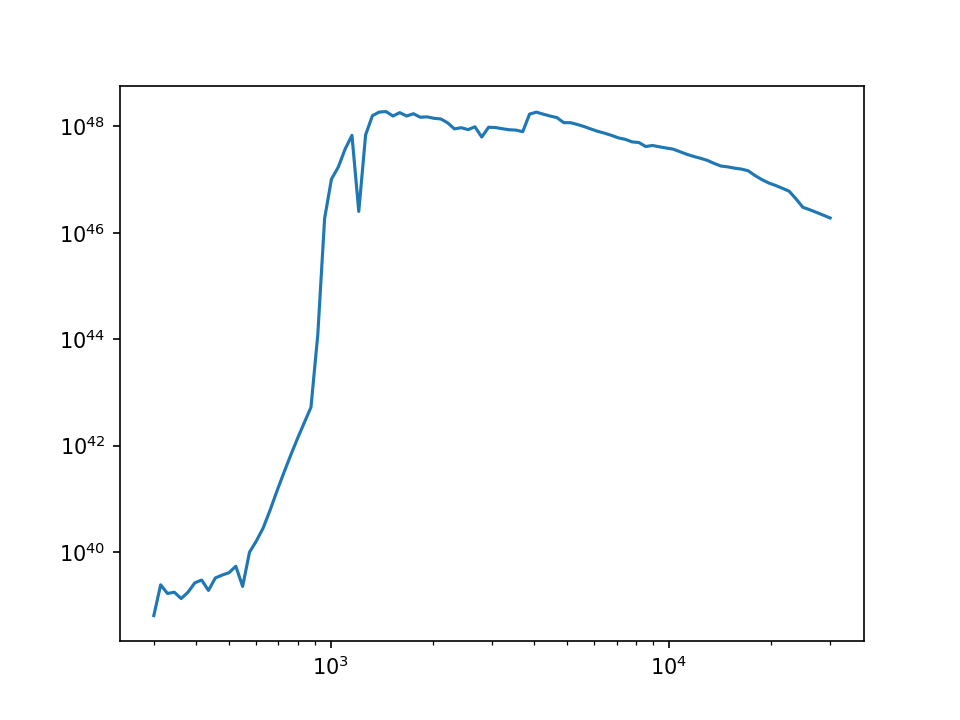

[29979.2458     28616.64281028 27315.97222939 26074.41913378
 24889.29654251 23758.03960205 22678.20003545 21647.4408437
 20663.53124804 19724.341862   18827.84008304 17972.08569354
 17155.22666176 16375.49513367 15631.20360692 14920.74127875
 14242.57055988 13595.22374683 12977.29984551 12387.46153917
 11824.43229417 11286.99359731 10773.98231866 10284.28819438
  9816.85142381  9370.66037588  8944.74939969  8538.19673471
  8150.12251579  7779.68686905  7426.08809416  7088.56092932
  6766.37489504  6458.83271325  6165.26879827  5885.04781629
  5617.56331043  5362.23638817  5118.51446858  4885.87008638
  4663.79975041  4451.82285393  4249.48063455  4056.33518133
  3871.96848704  3695.98154355  3527.99347824  3367.64072977
  3214.57626119  3068.46880894  2929.00216589  2795.87449701
  2668.79768614  2547.49671245  2431.70905522  2321.18412571
  2215.68272483  2114.97652543  2018.84757823  1927.08784003
  1839.49872356  1755.8906676   1676.08272683  1599.90218013
  1527.18415685  1457.771

In [4]:
## From Leo's Code (sed_eval)
%matplotlib notebook

## The function from sed_eval.ipynb file ##
# def non_param_sfr_sed(param): #
#     # param[0]: log10 SFR in the first 10 Myr
#     # param[1]: log10 SFR in the 10-100 Myr
#     # param[2]: log10 SFR in the 100 - 1000 Myr
#     p = np.power(10, param)
#     sfr_fn = lambda t: p[0] * (t<1e7) + p[1] * (t>1e7) * (t<1e8) + p[2] * (t>1e8) * (t<1e9)
#     sed_sim = generate_total_SED(sfr_fn, sed)
#     # interpolate the simulated sed to the designated wavelength grid
#     use_wave = (c.c/wave_freq/u.Hz).to(u.AA).value
#     sed_interpolate = np.interp(np.log10(use_wave), np.log10(sed.get_wavelength()), np.log10(sed_sim))
#     return np.power(10, sed_interpolate)


a=sed.sed.get_wavelength()/10**6
print(a.size)
obs = sed.non_param_sfr_sed([0,0,10])
plt.loglog(sed.use_wave,obs)

print(sed.use_wave)
print(a)



#plt.show(sed.get_wavelength(),obs)

In [10]:
## Intensity for each wavelength
# So maybe the flow goes like this --> We have a filter at each detector which detects only at a certain range of wavelength
# We also have the SED of an galaxy which is the amount of intensity that light gives per wavelength
# Another point is that the image of the galaxy we get is dependent on the 

## We WOULD LIKE TO GRAB A CERTAIN AMOUNT OF THE SED PROFILE ACCORDING TO THE WAVELENGTHS IN THE FILTER
## However USING THE CODE FROM LEO, THE WAVE 

# sed_wave=sed.sed.get_wavelength()/10**6

sed_wave = sed.use_wave/10**4 # Units in microns
formatted_string_sedwave=[]
for wave in sed_wave:
    formatted_string_sedwave.append("{:.4f}".format(wave))

for i in range(len(formatted_string_sedwave)):
    sed_wave[i]=float(formatted_string_sedwave[i])
    
print(sed_wave)



obs_intensity = sed.non_param_sfr_sed([0,0,10])
# plt.loglog(sed.use_wave,obs)

#Inputting and reading the file of the data
input_filename = input("Insert the filter file name: ")
data  = pd.read_csv("{0}.csv".format(input_filename))
xdata = data.microns # Wavelength in units of micrometer
ydata = data.throughput # The throughput for each wavelength in jwst_wave



jwst_waves=[]
for wave in xdata:
    jwst_waves.append(wave)

    
jwst_throughput=[]
for throughput in ydata:
    jwst_throughput.append(throughput)

plt.plot(jwst_waves,jwst_throughput)
plt.show()

#print(list_throughput)
    
# sfr_waves_microns = sed.use_wave/10**4 # Changing the units of use_wave into micrometer
# print(sfr_waves_microns)

list_throughput=[]
list_wave=[]
list_sfr_intensity=[]

# The for loop for eliminating the wavelength that is not within the filter bandwidth range
# for i in range(len(jwst_waves)):
#     for j in range(len(sfr_waves_microns)):
#         if jwst_waves[i]==sfr_waves_microns[j]:
#             list_throughput.append(jwst_throughput[i])
#             list_wave.append(jwst_waves[i])
#             list_sfr_intensity.append(obs[j])


# for wave in jwst_wave: 
#     for i in range(len(use_wave_microns)):
#         if use_wave_microns[i]==wave:
            
            
    # The wave in data_wave harus dicocokin sama si wave di use_wave
#     for i in range
#     ()
# for i in use_wave:
#     print(i)


    
# for i in range(len(use_wave)):
#     integrand = obs[i]*throughput[i]
    
# def flux_density(wavelength):
    
#     return

# def efficiency(wavelength):
#     return

[2.9979 2.8617 2.7316 2.6074 2.4889 2.3758 2.2678 2.1647 2.0664 1.9724
 1.8828 1.7972 1.7155 1.6375 1.5631 1.4921 1.4243 1.3595 1.2977 1.2387
 1.1824 1.1287 1.0774 1.0284 0.9817 0.9371 0.8945 0.8538 0.815  0.778
 0.7426 0.7089 0.6766 0.6459 0.6165 0.5885 0.5618 0.5362 0.5119 0.4886
 0.4664 0.4452 0.4249 0.4056 0.3872 0.3696 0.3528 0.3368 0.3215 0.3068
 0.2929 0.2796 0.2669 0.2547 0.2432 0.2321 0.2216 0.2115 0.2019 0.1927
 0.1839 0.1756 0.1676 0.16   0.1527 0.1458 0.1392 0.1328 0.1268 0.121
 0.1155 0.1103 0.1053 0.1005 0.0959 0.0916 0.0874 0.0834 0.0796 0.076
 0.0726 0.0693 0.0661 0.0631 0.0602 0.0575 0.0549 0.0524 0.05   0.0477
 0.0456 0.0435 0.0415 0.0396 0.0378 0.0361 0.0345 0.0329 0.0314 0.03  ]
Insert the filter file name: F444W


In [9]:
%matplotlib notebook
input_filename = input("Insert the filter file name: ")
data  = pd.read_csv("{0}.csv".format(input_filename))
xdata = data.microns # Wavelength in units of micrometer
ydata = data.throughput # The throughput for each wavelength in jwst_wave
sed_waves = sed.use_wave/10**4


jwst_waves=[]
for wave in xdata:
    jwst_waves.append(wave)

    
jwst_throughput = []
for throughput in ydata:
    jwst_throughput.append(throughput)
    
minima_throughput=[]
maxima_throughput=[]
extrema_throughput=[]

# For getting the points of minima and maxima of the bandwidth function
for i in range(len(jwst_throughput)):
    if i!=0 and i!=len(jwst_throughput)-1:
        if jwst_throughput[i]-jwst_throughput[i+1]>0 and jwst_throughput[i]-jwst_throughput[i-1]>0:
            extrema_throughput.append(jwst_throughput[i])

        elif jwst_throughput[i]-jwst_throughput[i+1]<0 and jwst_throughput[i]-jwst_throughput[i-1]<0:
            extrema_throughput.append(jwst_throughput[i])

# Interpolating the throughput values of the generated SED waves
within_filtersed_throughput=[]
within_filtersed_waves = []
for i in range(len(extrema_throughput)-1):
    waves_section=[]
    for wave in sed_waves:
        if wave-jwst_waves[jwst_throughput.index(extrema_throughput[i])]>0 and wave-jwst_waves[jwst_throughput.index(extrema_throughput[i+1])]<0:
            waves_section.append(wave)
            for wave in waves_section:
                a=np.interp(wave,jwst_waves[jwst_throughput.index(extrema_throughput[i]):jwst_throughput.index(extrema_throughput[i+1])+1]
                            ,jwst_throughput[jwst_throughput.index(extrema_throughput[i]):jwst_throughput.index(extrema_throughput[i+1])+1])
                within_filtersed_throughput.append(a)
                within_filtersed_waves.append(wave)
    
# print(len(extrema_throughput))

# print(len(jwst_throughput))

print(len(within_filtersed_throughput))
print(len(sed_waves))
print(len(within_filtersed_waves))


# plt.plot(within_filter_waves,sed_throughput)
# plt.show()

# plt.plot(jwst_waves,jwst_throughput)
# plt.show()

print(within_filtersed_waves)
print(within_filtersed_throughput)

# Now we would like to times the SED intensity of the within_filter_sed waves and 


